In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cardio_train.csv", sep=";")

df.head(10)


C:\Users\MaxF�rsntr�m-AI23GBG\AppData\Local\Temp\ipykernel_1428\777005197.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


## EDA för dataset 1

Börjar med att titta på hur många posstiva och negativa det finns för hjärt-kärlsjukdom:

Text(0, 0.5, 'count of tested people')

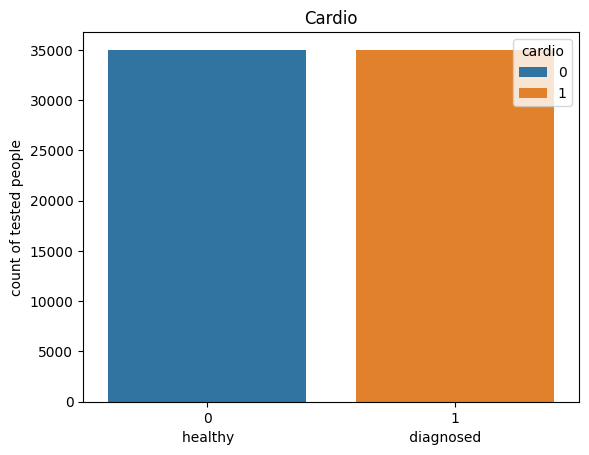

In [4]:
sns.countplot(data=df, x="cardio", hue="cardio")
plt.title("Cardio")
plt.xlabel("healthy                                        diagnosed")
plt.ylabel("count of tested people")

Lite svårt att se men man kan se att det är mer testade som är friska än sjuka men skillnaden är minimal

Text(0.5, 1.0, 'Cholesterol levels')

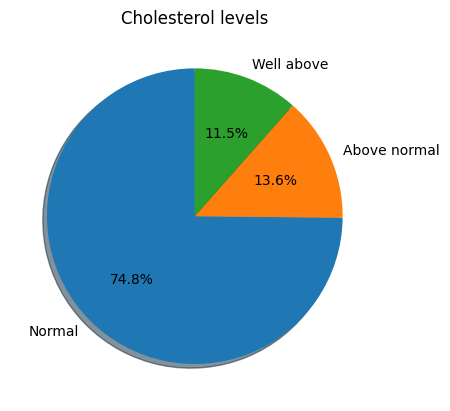

In [5]:
# Hur stor andel har normala, över normala och långt över normala kolesterolvärden?
values = ["Normal", "Above normal", "Well above"]
cholesterol_count = df["cholesterol"].value_counts()
explode = (0, 0.1, 0, 0)

plt.pie(cholesterol_count, labels=values, autopct="%1.1f%%", startangle=90, shadow=True)
plt.title("Cholesterol levels")

In [6]:
# Hur ser åldersfördelningen ut?

df["age"] = df["age"] / 365
df["age"] = df["age"].astype("int")

Text(0, 0.5, 'People of each age group')

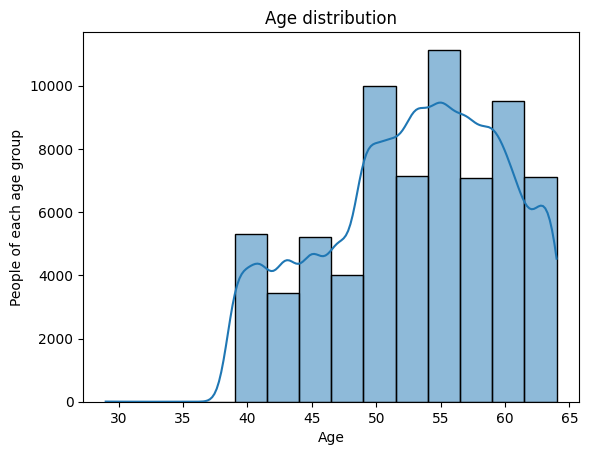

In [8]:
sns.histplot(df["age"], bins=14, kde=True)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("People of each age group")

Text(0.5, 1.0, 'Smokers in dataset')

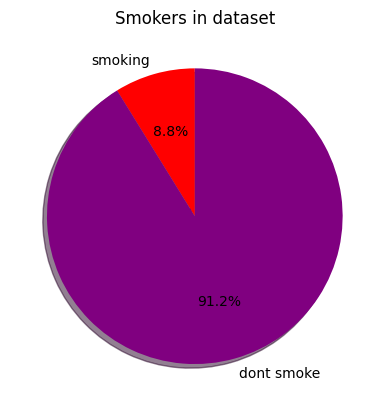

In [9]:
# Hur stor andel röker(i %)?

percentage_smoke = (df["smoke"].sum() / len(df)) * 100

plt.pie([percentage_smoke, 100 - percentage_smoke], labels=["smoking", "dont smoke"], autopct="%1.1f%%", startangle=90, shadow=True, colors=['red', 'purple'])
plt.title("Smokers in dataset")

[Text(0.5, 1.0, 'weight distribution'),
 Text(0.5, 0, 'Weight'),
 Text(0, 0.5, 'People')]

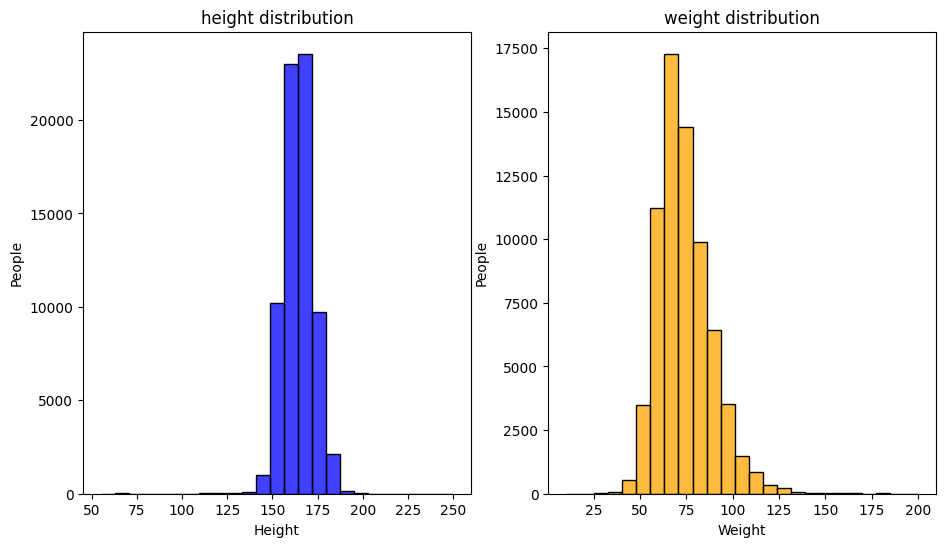

In [10]:
# Hur ser vikt och längdfördelningen ut?
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

sns.histplot(df["height"], bins=25, color="blue" , ax=ax1)
sns.histplot(df["weight"], bins=25, color="orange", ax=ax2)
ax1.set(title="height distribution", xlabel="Height", ylabel="People")
ax2.set(title="weight distribution", xlabel="Weight", ylabel="People")

(-1.1031348296590868,
 1.1658457106000661,
 -1.1326579969198578,
 1.1015551427104695)

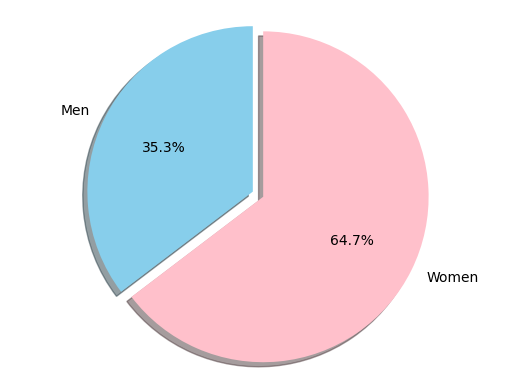

In [11]:
# Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom?

df_men_cardio = df[(df["gender"] == 2) & (df["cardio"] == 1)]
df_women_cardio = df[(df["gender"] == 1) & (df["cardio"] == 1)]

data = [len(df_men_cardio), len(df_women_cardio)]
explode = (0, 0.07)

plt.pie(data, labels=["Men", "Women"], autopct="%1.1f%%", startangle=90, shadow=True, colors=["skyblue", "pink"], explode=explode)
plt.axis("equal")

## Modelldesign för dataset 1

<Axes: xlabel='bmi', ylabel='Count'>

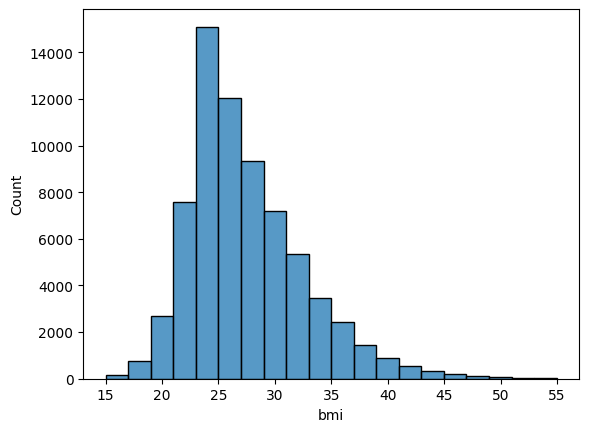

In [12]:
# Släng de samples med orimliga BMIer och outliers. Beskriv hur du kommer fram till gränserna, med resonemang eller referens.

df["bmi"] = round(df["weight"] / ((df["height"] / 100) ** 2), 2)

lower_limit = 15
upper_limit = 55

outliers_df = df[(df["bmi"] < lower_limit) | (df["bmi"] > upper_limit)]

df = df.drop(outliers_df.index)


sns.histplot(df["bmi"], bins=20) 


Jag valde här outliers som lower_limit till 15 och upper_limit till 55.

enligt: https://sv.wikipedia.org/wiki/BMI_(kroppsmasseindex), så är mindre än 18.5 undervikt och mer än 40 är fetma klass 3. Jag valde då dessa limits eftersom att bortom om det är under eller över dessa gränser så klasses det som livshotande


In [13]:
# Skapa en kategorisk BMI-feature med kategorierna: normal range, overweight, obese (class I), obese (class II), obese (class III).

def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal range"
    elif bmi < 30:
        return "Overweight"
    elif bmi < 35:
        return "obese class 1"
    elif bmi < 40:
        return "obese class 2"
    else:
        return "obese class 3"
    
df['BMI_category'] = df['bmi'].apply(categorize_bmi)

In [14]:
# Skapa en feature för blodtryckskategorier enligt tabellen i denna artikel.

def categorize_blood_pressure(systolic, diastolic):
    if systolic < 120 and diastolic < 80:
        return "Normal"
    elif systolic < 130 and diastolic < 80:
        return "Elevated"
    elif systolic < 140 and diastolic < 90:
        return "Stage 1 hypertension"
    elif systolic < 180 and diastolic < 120:
        return "Stage 2 hypertension"
    else: 
        return "Hypersensitive emergency"

df["Blood_pressure_category"] = df.apply(lambda row: categorize_blood_pressure(row["ap_hi"], row["ap_lo"]), axis=1)

df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,BMI_category,Blood_pressure_category
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.97,Normal range,Stage 1 hypertension
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,obese class 1,Stage 2 hypertension
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.51,Normal range,Stage 1 hypertension
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.71,Overweight,Stage 2 hypertension
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.01,Normal range,Normal
5,8,60,1,151,67.0,120,80,2,2,0,0,0,0,29.38,Overweight,Stage 1 hypertension
6,9,60,1,157,93.0,130,80,3,1,0,0,1,0,37.73,obese class 2,Stage 1 hypertension
7,12,61,2,178,95.0,130,90,3,3,0,0,1,1,29.98,Overweight,Stage 2 hypertension
8,13,48,1,158,71.0,110,70,1,1,0,0,1,0,28.44,Overweight,Normal
9,14,54,1,164,68.0,110,60,1,1,0,0,0,0,25.28,Overweight,Normal


In [15]:
lower_systolic = 90
upper_systolic = 200
lower_diastolic = 50
upper_diastolic = 120

outliers_blood_df = df[(df["ap_hi"] >= lower_systolic) & (df["ap_hi"] <= upper_systolic) & 
                 (df["ap_lo"] >= lower_diastolic) & (df["ap_lo"] <= upper_diastolic)]

df = df.drop(outliers_blood_df.index)

för att få blood_pressure datan använde jag mig av denna sida:

https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/blood-pressure/art-20050982, 


tog det mesta ifrån tabellen där.

<Axes: >

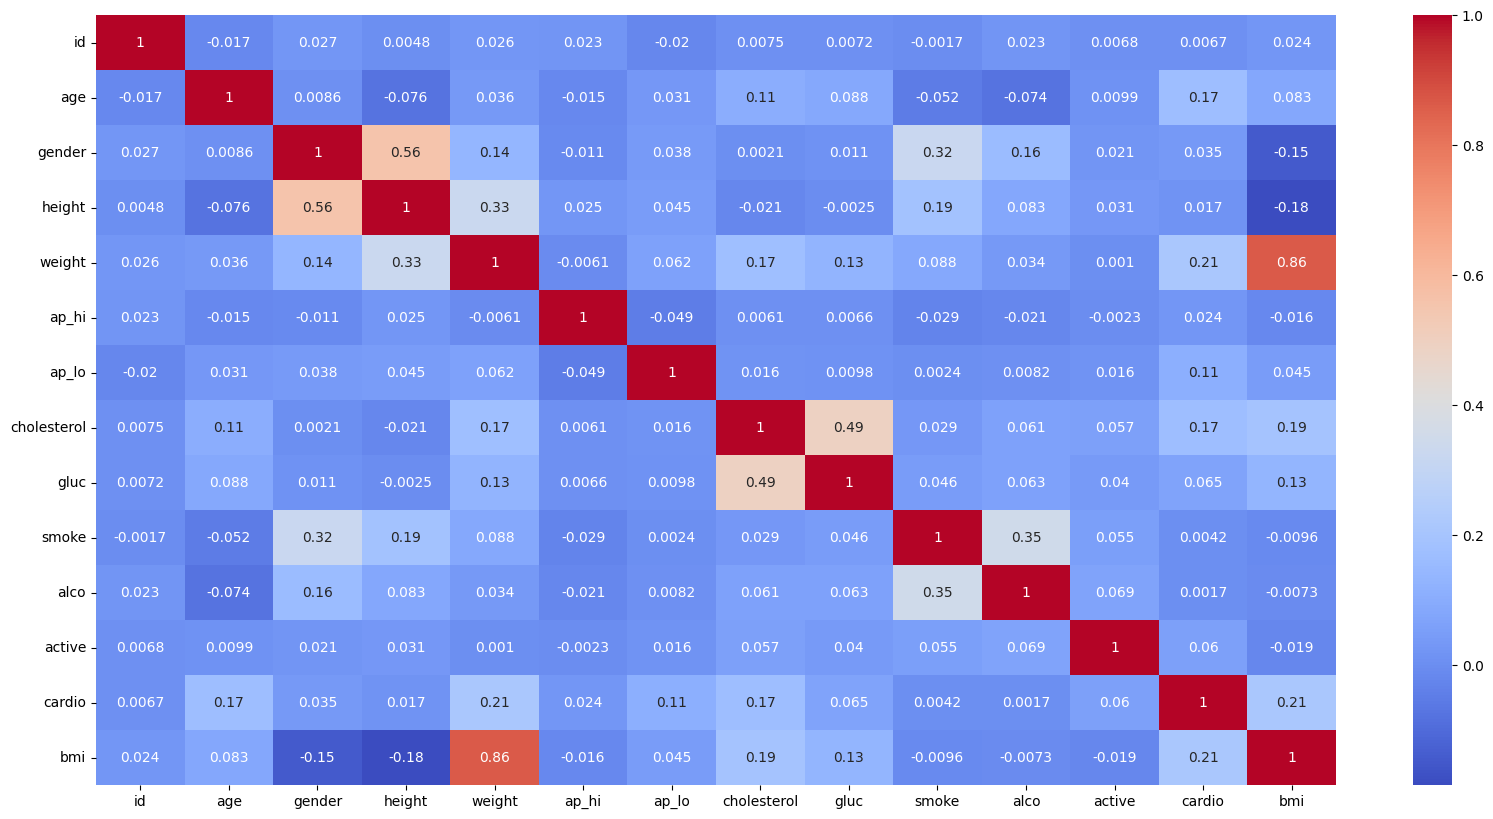

In [16]:
# heatmap för correlation 

df_for_correlation = df.drop(columns=["Blood_pressure_category", "BMI_category"]) # had to remove these here because numeric values

plt.figure(figsize=(20, 10))
sns.heatmap(df_for_correlation.corr(), annot=True, cmap="coolwarm")

### Correlationsanalys

Det verkar inte var några speciella värden relevanta från korrelationen. De med högst värden verkar vara gender, cholesterol och möjligtvis weight

de med flest negativa värden verkar vara ap_hi och bmi.

de som ska vara korrelerade verkar vara det också med ungefär samma värden så det verkar stämma. 

In [17]:
# Skapar kopior av datasetet
copy_df = df

df_n1 = copy_df.drop(["id", "ap_hi", "ap_lo", "height", "weight", "bmi"], axis=1)
df_n1_dummies = pd.get_dummies(df_n1, columns=['BMI_category', "Blood_pressure_category", "gender"])

non_numeric_values_BMI = {'Underweight': 1, 'Normal range': 2, 'Overweight': 3, 'obese class 1': 4, 'obese class 2': 5, 'obese class 3': 6}
non_numeric_values_blood = {'Normal': 1, 'Elevated': 2, 'Stage 1 hypertension': 3, 'Stage 2 hypertension': 4, 'Hypersensitive emergency': 5}

# ersätter non numeric values
df_n1.replace(non_numeric_values_BMI, inplace=True)
df_n1.replace(non_numeric_values_blood, inplace=True)

df_n2 = copy_df.drop(["id", "BMI_category", "Blood_pressure_category", "height", "weight"], axis=1)
df_n2_dummies = pd.get_dummies(df_n2, columns=["gender"])

display(df_n1.head(10), df_n2.head(10))

C:\Users\MaxF�rsntr�m-AI23GBG\AppData\Local\Temp\ipykernel_1428\998345612.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_n1.replace(non_numeric_values_BMI, inplace=True)
C:\Users\MaxF�rsntr�m-AI23GBG\AppData\Local\Temp\ipykernel_1428\998345612.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_n1.replace(non_numeric_values_blood, inplace=True)


,age,gender,cholesterol,gluc,smoke,alco,active,cardio,BMI_category,Blood_pressure_category
209,49,2,1,1,0,0,1,0,2,1
228,47,2,1,2,1,0,1,1,3,5
241,60,2,2,1,0,0,0,1,2,5
260,49,1,1,1,0,0,1,1,5,5
329,64,1,2,2,0,0,0,1,2,5
345,51,1,2,1,0,0,1,1,4,5
383,53,1,1,1,0,0,1,0,2,1
418,45,1,1,1,0,0,1,1,3,4
473,41,1,1,1,0,0,1,1,6,5
474,52,1,2,1,0,0,1,0,3,5


,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
209,49,2,80,70,1,1,0,0,1,0,20.96
228,47,2,160,1100,1,2,1,0,1,1,29.26
241,60,2,160,1000,2,1,0,0,0,1,24.34
260,49,1,140,800,1,1,0,0,1,1,36.89
329,64,1,160,1000,2,2,0,0,0,1,20.34
345,51,1,140,1000,2,1,0,0,1,1,34.15
383,53,1,80,50,1,1,0,0,1,0,18.97
418,45,1,150,30,1,1,0,0,1,1,29.21
473,41,1,150,1033,1,1,0,0,1,1,42.22
474,52,1,120,150,2,1,0,0,1,0,26.71


In [18]:
# utförandet

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier()
log_reg = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()

In [19]:
# starting with a train|test split
X_1, y_1 = df_n1.drop("cardio", axis=1), df_n1["cardio"]
X_2, y_2 = df_n2.drop("cardio", axis=1), df_n2["cardio"]

X_train_1 , X_test_1, y_train_1, y_test_1 = train_test_split(X_1,  y_1, test_size=0.3, random_state=42)
X_train_2 , X_test_2, y_train_2, y_test_2 = train_test_split(X_2,  y_2, test_size=0.3, random_state=42)

In [ ]:
rf = RandomForestClassifier()
log_reg = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()

models = {"KNN": KNeighborsClassifier(), "LR": LogisticRegression(), "RF": RandomForestClassifier(), "SVM": SVC()}

scaler = StandardScaler()

# hyperparameters
svm_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}
rf_params = {'max_leaf_nodes': [1, 2, 3], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 10]}
k_neigh_params = {'n_neighbors': [1, 2, 5, 10, 15, 20], 'weights': ['uniform', 'distance'], "metric": ['euclidean', 'manhattan', 'minkowski']}
log_reg_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# dictionary of hyperparameters 
param_grids = {'KNN': k_neigh_params, 'LR': log_reg_params, 'RF': rf_params, 'SVM': svm_params}

# making a loop for the grid search of the models
for model_name, model in models.items():
    grid = GridSearchCV(model, param_grid=param_grids[model_name], scoring='accuracy', cv=5)

    grid.fit(X_train_1, y_train_1)
    print(f"{model_name} with Training Set 1:")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Score: {grid.best_score_}\n")
    
    grid.fit(X_train_2, y_train_2)
    print(f"{model_name} with Training Set 2:")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Score: {grid.best_score_}\n")
 


                                        KNN
________________________________________________________________________________________
* Best parameters: metric: euclidean, n_neighbours: 20, weights: unifrom
* Weights: "unifrom"
* Metrics: "euclidean"
* Best_score_1: 0.7977042694147959
* Best_score_2:  0.8159182922340819
                 
                                        LR
________________________________________________________________________________________
* Best Parameters: {'penalty': 'l2', 'solver': 'newton-cg'}
* Penalty: "l2"
* Solver: "newton-cg
* Best Score_1: 0.8101306588148693
* Best Score_2: 0.7622101582627898

                                        RF
________________________________________________________________________________________
* Best Parameters: {'max_depth': 6, 'max_leaf_nodes': 3, 'min_samples_split': 5}
* Max_depth: "6"
* Max_leaf_nodes: "3"
* Min_samples_split: "5"
* Best Score_1: 0.7928827751196172
* Best_Score_2: 0.8034136915715863

                                        SVM
________________________________________________________________________________________
* Best Parameters: {'gamma': 'scale', 'kernel': 'linear'}
* Gamma: "scale"
* Kernel: "linear"
* Best Score_1: 0.8005566801619434
* Best Score_2: 0.7961647841810145

De båda dataseten verkar inte skilja sig åt allt för mycket men jag skulle vilja påpeka av dessa resultat att dataset 1 är det bättre

## Packetering och demo

In [38]:
# Spara modell

import random

test_samples = random.sample(range(0, len(df_n1)), 100)
test_samples_df = df_n1.iloc[test_samples]
test_samples_df.to_csv('test_samples.csv', index=False)

df_2 = df_n1.drop(test_samples_df.index)

In [39]:
# Ladda modell

import joblib

test_samples = pd.read_csv("test_samples.csv")

model = joblib.load('new_rf_model.pkl')

X_test = test_samples.drop('cardio', axis=1)
y_test = test_samples['cardio']

y_pred = model.predict_proba(X_test)

print("Accuracy score: ", model.score(X_test, y_test))

predictions = pd.DataFrame(y_pred, columns=['Probability class 0', 'Probability class 1'])
predictions['Prediction'] = model.predict(X_test)

predictions.to_csv('predictions.csv', index=False)

Accuracy score:  0.84
